# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5]
regularization_strengths = [1e3, 5e3, 1e4, 5e4, 1e5, 5e5]


results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        newSvm = LinearSVM()
        # Training
        newSvm.train(X_train_feats, y_train, learning_rate, reg_strength,
                              num_iters=1500, verbose=True)
        
        # Prediction
        new_y_train_pred = newSvm.predict(X_train_feats)
        training_acc = np.mean(y_train == new_y_train_pred)
        new_y_val_pred = newSvm.predict(X_val_feats)
        validation_acc = np.mean(y_val == new_y_val_pred)
        
        # Storing results
        results[(learning_rate, reg_strength)] = (training_acc, validation_acc)
        if (validation_acc > best_val):
            best_val = validation_acc
            best_svm = newSvm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 9.011334
iteration 100 / 1500: loss 8.996928
iteration 200 / 1500: loss 9.002388
iteration 300 / 1500: loss 8.997525
iteration 400 / 1500: loss 9.002056
iteration 500 / 1500: loss 8.995450
iteration 600 / 1500: loss 8.995371
iteration 700 / 1500: loss 9.012820
iteration 800 / 1500: loss 9.000773
iteration 900 / 1500: loss 9.007352
iteration 1000 / 1500: loss 8.990122
iteration 1100 / 1500: loss 9.006162
iteration 1200 / 1500: loss 9.000697
iteration 1300 / 1500: loss 8.988494
iteration 1400 / 1500: loss 8.990365
iteration 0 / 1500: loss 9.001696
iteration 100 / 1500: loss 8.997651
iteration 200 / 1500: loss 9.013047
iteration 300 / 1500: loss 9.013490
iteration 400 / 1500: loss 9.006131
iteration 500 / 1500: loss 8.994499
iteration 600 / 1500: loss 9.006986
iteration 700 / 1500: loss 8.998765
iteration 800 / 1500: loss 9.015477
iteration 900 / 1500: loss 9.000736
iteration 1000 / 1500: loss 8.990828
iteration 1100 / 1500: loss 9.005857
iteration 1200 / 1500: lo

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.441


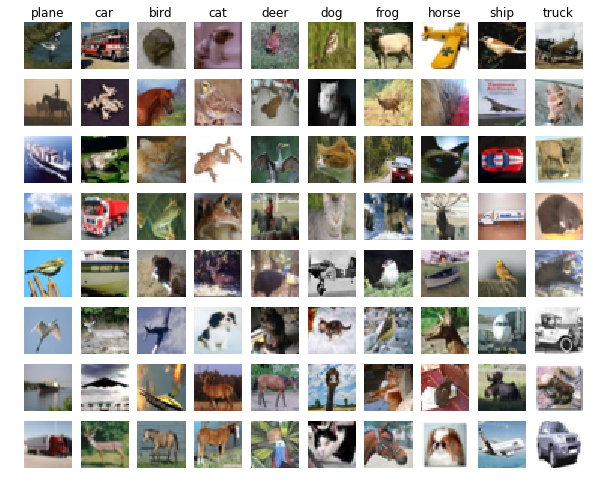

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
Some of the misclassifications are quite understandable. The white or blue background of certain classes may have caused them to have been misclassified as planes while the brown predominant color of certain classes (such as dogs and cats) caused them to have been misclassified as trucks (which are likely to have plenty of brown colors).

Misclassifications of other classes into dog / cat / birds / horses are also consistent in the sense that the misclassified classes are usually living things and not objects.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
print X_train_feats.shape

(49000, 155)


In [9]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

best_val_acc = -1

learning_rates = [1e-2 ,1e-1, 5e-1, 1, 5]
regularization_strengths = [1e-3, 5e-3, 1e-2, 1e-1, 0.5, 1]

for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=1500, batch_size=200,
                    learning_rate=learning_rate, learning_rate_decay=0.95,
                    reg=reg_strength, verbose=False)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print '[LR: %f][REG: %f] Validation accuracy: %f' % (learning_rate, reg_strength, val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

[LR: 0.010000][REG: 0.001000] Validation accuracy: 0.174000
[LR: 0.010000][REG: 0.005000] Validation accuracy: 0.203000
[LR: 0.010000][REG: 0.010000] Validation accuracy: 0.110000
[LR: 0.010000][REG: 0.100000] Validation accuracy: 0.089000
[LR: 0.010000][REG: 0.500000] Validation accuracy: 0.078000
[LR: 0.010000][REG: 1.000000] Validation accuracy: 0.078000
[LR: 0.100000][REG: 0.001000] Validation accuracy: 0.528000
[LR: 0.100000][REG: 0.005000] Validation accuracy: 0.509000
[LR: 0.100000][REG: 0.010000] Validation accuracy: 0.517000
[LR: 0.100000][REG: 0.100000] Validation accuracy: 0.434000
[LR: 0.100000][REG: 0.500000] Validation accuracy: 0.098000
[LR: 0.100000][REG: 1.000000] Validation accuracy: 0.105000
[LR: 0.500000][REG: 0.001000] Validation accuracy: 0.581000
[LR: 0.500000][REG: 0.005000] Validation accuracy: 0.579000
[LR: 0.500000][REG: 0.010000] Validation accuracy: 0.554000
[LR: 0.500000][REG: 0.100000] Validation accuracy: 0.379000
[LR: 0.500000][REG: 0.500000] Validation

cs231n/classifiers/neural_net.py:129: RuntimeWarning: divide by zero encountered in log
  data_loss = np.sum(-np.log(correct_probs))
cs231n/classifiers/neural_net.py:123: RuntimeWarning: overflow encountered in subtract
  scores -= normalization_term



[LR: 5.000000][REG: 0.500000] Validation accuracy: 0.087000
[LR: 5.000000][REG: 1.000000] Validation accuracy: 0.087000


cs231n/classifiers/neural_net.py:123: RuntimeWarning: invalid value encountered in subtract
  scores -= normalization_term
cs231n/classifiers/neural_net.py:133: RuntimeWarning: overflow encountered in double_scalars
  reg_loss = 0.5 * reg * (np.sum(W2 * W2) + np.sum(W1 * W1))
cs231n/classifiers/neural_net.py:161: RuntimeWarning: invalid value encountered in greater
  dz1 = np.multiply((z1 > 0), da1)  # (da1 / dz1) = (z1 > 0)


In [10]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.572


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

In [15]:
# Implement PCA to extract principal components of the images as the features
X_train_rows = np.reshape(X_train, (X_train.shape[0], -1))
X_val_rows = np.reshape(X_val, (X_val.shape[0], -1))
X_test_rows = np.reshape(X_test, (X_test.shape[0], -1))

# Preprocessing: Subtract the mean feature
mean_rows = np.mean(X_train_rows, axis=0, keepdims=True)
X_train_rows -= mean_rows
X_val_rows -= mean_rows
X_test_rows -= mean_rows

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_rows = np.std(X_train_rows, axis=0, keepdims=True)
X_train_rows /= std_rows
X_val_rows /= std_rows
X_test_rows /= std_rows

# Covariance matrix
cov = np.dot(X_train_rows.T, X_train_rows) / X_train_rows.shape[0]

# Perform SVD only on 10,000 images. Else, it would take a few mins.
#U, s, Vh = np.linalg.svd(X_train_rows, full_matrices=False)
U, S, V = np.linalg.svd(cov, full_matrices=False)

In [18]:
# Number of dimensions to project onto
#
# NOTE: IMPORTANT because the lesser the number of dimensions,
# the faster the training time. However, it may also compromise
# performance.
#
# Original image was 32 x 32 x 3 = 3072.
# Therefore, 1 <= K <= 3072
#
K = 1000

# Keep only the top K eigenvectors in U
U_reduced = U[0:K, :]

X_train_pca = np.dot(X_train_rows, U_reduced.T)
X_val_pca = np.dot(X_val_rows, U_reduced.T)
X_test_pca = np.dot(X_test_rows, U_reduced.T)

In [19]:
# Find a learning_rate and regularization strength for training the model
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
regularization_strengths = [1e3, 5e3, 1e4, 5e4, 1e5, 5e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        newSvm = LinearSVM()
        # Training
        newSvm.train(X_train_pca, y_train, learning_rate, reg_strength,
                              num_iters=1500, verbose=True)
        
        # Prediction
        new_y_train_pred = newSvm.predict(X_train_pca)
        training_acc = np.mean(y_train == new_y_train_pred)
        new_y_val_pred = newSvm.predict(X_val_pca)
        validation_acc = np.mean(y_val == new_y_val_pred)
        
        # Storing results
        results[(learning_rate, reg_strength)] = (training_acc, validation_acc)
        if (validation_acc > best_val):
            best_val = validation_acc
            best_svm = newSvm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 8.990436
iteration 100 / 1500: loss 8.465976
iteration 200 / 1500: loss 8.052498
iteration 300 / 1500: loss 7.207764
iteration 400 / 1500: loss 6.790685
iteration 500 / 1500: loss 6.785344
iteration 600 / 1500: loss 6.461888
iteration 700 / 1500: loss 6.768283
iteration 800 / 1500: loss 6.820418
iteration 900 / 1500: loss 6.447158
iteration 1000 / 1500: loss 5.659723
iteration 1100 / 1500: loss 5.844671
iteration 1200 / 1500: loss 6.578924
iteration 1300 / 1500: loss 5.970643
iteration 1400 / 1500: loss 5.625603
iteration 0 / 1500: loss 8.947035
iteration 100 / 1500: loss 8.354194
iteration 200 / 1500: loss 7.798580
iteration 300 / 1500: loss 7.364903
iteration 400 / 1500: loss 6.722857
iteration 500 / 1500: loss 6.521094
iteration 600 / 1500: loss 6.688818
iteration 700 / 1500: loss 6.375367
iteration 800 / 1500: loss 6.869862
iteration 900 / 1500: loss 6.194400
iteration 1000 / 1500: loss 5.738431
iteration 1100 / 1500: loss 6.690335
iteration 1200 / 1500: lo

In [14]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_pca)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.335


In [20]:
# Number of dimensions to project onto
#
# NOTE: IMPORTANT because the lesser the number of dimensions,
# the faster the training time. However, it may also compromise
# performance.
#
# Original image was 32 x 32 x 3 = 3072.
# Therefore, 1 <= K <= 3072
#
K = 1000

# Keep only the top K eigenvectors in U
U_reduced = U[0:K, :]

X_train_pca = np.dot(X_train_rows, U_reduced.T)
X_val_pca = np.dot(X_val_rows, U_reduced.T)
X_test_pca = np.dot(X_test_rows, U_reduced.T)

In [22]:
input_dim = X_train_pca.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

best_val_acc = -1

learning_rates = [5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
regularization_strengths = [1e-6, 1e-5, 1e-4, 1e-3, 5e-3, 1e-2]

for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(X_train_pca, y_train, X_val_pca, y_val,
                    num_iters=1500, batch_size=200,
                    learning_rate=learning_rate, learning_rate_decay=0.95,
                    reg=reg_strength, verbose=False)

        # Predict on the validation set
        val_acc = (net.predict(X_val_pca) == y_val).mean()
        print '[LR: %f][REG: %f] Validation accuracy: %f' % (learning_rate, reg_strength, val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

[LR: 0.000050][REG: 0.000001] Validation accuracy: 0.109000
[LR: 0.000050][REG: 0.000010] Validation accuracy: 0.155000
[LR: 0.000050][REG: 0.000100] Validation accuracy: 0.079000
[LR: 0.000050][REG: 0.001000] Validation accuracy: 0.079000
[LR: 0.000050][REG: 0.005000] Validation accuracy: 0.079000
[LR: 0.000050][REG: 0.010000] Validation accuracy: 0.108000
[LR: 0.000100][REG: 0.000001] Validation accuracy: 0.087000
[LR: 0.000100][REG: 0.000010] Validation accuracy: 0.090000
[LR: 0.000100][REG: 0.000100] Validation accuracy: 0.078000
[LR: 0.000100][REG: 0.001000] Validation accuracy: 0.078000
[LR: 0.000100][REG: 0.005000] Validation accuracy: 0.081000
[LR: 0.000100][REG: 0.010000] Validation accuracy: 0.078000
[LR: 0.000500][REG: 0.000001] Validation accuracy: 0.094000
[LR: 0.000500][REG: 0.000010] Validation accuracy: 0.079000
[LR: 0.000500][REG: 0.000100] Validation accuracy: 0.087000
[LR: 0.000500][REG: 0.001000] Validation accuracy: 0.078000
[LR: 0.000500][REG: 0.005000] Validation

In [23]:
test_acc = (best_net.predict(X_test_pca) == y_test).mean()
print test_acc

0.492


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!